# Notebook 2: Pronóstico Top 50 jugadores – Temporada 2025/2026

### Objetivo
En este notebook proyectamos el **valor de mercado de los jugadores más valiosos para la próxima temporada (2025–2026)**.  
Usamos el modelo **XGBoost**, previamente entrenado en el dataset de 2024–2025.

- Seleccionar los jugadores más caros actualmente (Top 50 Transfermarkt 24/25).
- Predecir su valor esperado para la próxima temporada (25/26).
- Comparar entre **valor oficial actual** y **valor proyectado**.
- Mostrar tabla (Top 50) + gráfico visual (Top 20).

---


In [1]:
# ========================================
# 1. Importar librerías
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from xgboost import XGBRegressor

# ========================================
# 2. Cargar dataset final (dataset_model.csv)
# ========================================
df = pd.read_csv("../data/processed/dataset_model.csv")

print("[i] Dataset cargado:", df.shape)
df.head()


[i] Dataset cargado: (6849, 275)


,Player,Squad,Pos,Age,Born,season,Competition,player_key,squad_key,season_key,...,Nation_us USA,Nation_uy URU,Nation_uz UZB,Nation_ve VEN,Nation_wls WAL,Nation_xk KVX,Nation_za RSA,Nation_zm ZAM,Nation_zw ZIM,market_value_log
0,Anthony Khelifa,Ajaccio,DF,16.0,2005.0,2022-2023,big5,anthony khelifa,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,0.000000
1,Ben Hamed Touré,Ajaccio,FW,18.0,2003.0,2022-2023,big5,ben hamed toure,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,0.000000
2,Benjamin Leroy,Ajaccio,GK,33.0,1989.0,2022-2023,big5,benjamin leroy,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,13.304687
3,Bevic Moussiti-Oko,Ajaccio,FW,27.0,1995.0,2022-2023,big5,bevic moussiti-oko,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,13.458837
4,Clément Vidal,Ajaccio,"DF,MF",22.0,2000.0,2022-2023,big5,clement vidal,ajaccio,2022-2023,...,False,False,False,False,False,False,False,False,False,14.220976


### Preparación de datos
- Nos enfocamos en la **temporada actual 2024/2025** como base.
- Se filtra el **Top 50 más caro** según Transfermarkt.
- Se proyecta el valor para la **temporada 2025/2026**.


In [2]:
# ========================================
# 3. Seleccionar temporada actual (2024/25)
# ========================================
df_current = df[df["season"] == "2024-2025"].copy()

# Ordenar por valor de Transfermarkt y tomar Top 50
top50_current = df_current.sort_values("market_value_in_eur", ascending=False).head(50)

print("[i] Top 50 jugadores actuales:", top50_current.shape)
top50_current[["Player","season","market_value_in_eur"]].head(10)


[i] Top 50 jugadores actuales: (50, 275)


,Player,season,market_value_in_eur
5928,Erling Haaland,2024-2025,200000000.0
4957,Lamine Yamal,2024-2025,180000000.0
6310,Jude Bellingham,2024-2025,180000000.0
6311,Kylian Mbappé,2024-2025,160000000.0
4804,Bukayo Saka,2024-2025,150000000.0
4972,Jamal Musiala,2024-2025,140000000.0
5806,Florian Wirtz,2024-2025,140000000.0
5937,Phil Foden,2024-2025,140000000.0
5939,Rodri,2024-2025,130000000.0
6307,Federico Valverde,2024-2025,130000000.0


### Modelo XGBoost
Reutilizamos el modelo ya entrenado para hacer la **predicción de la siguiente temporada**.


In [3]:
from sklearn.model_selection import train_test_split

# ========================================
# 4. Variables predictoras y target
# ========================================
X = df.drop(columns=["market_value_log","market_value_in_eur"])
y = df["market_value_log"]

# One-hot encoding de categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Reconstrucción de train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# ========================================
# 5. Entrenar modelo XGBoost
# ========================================
xgb = XGBRegressor(
    n_estimators=500, learning_rate=0.1, max_depth=6,
    random_state=42, n_jobs=-1
)
xgb.fit(X_train, y_train)

print("[i] Modelo XGBoost entrenado para pronóstico.")


[i] Modelo XGBoost entrenado para pronóstico.


### Predicción temporada 2025/26
Se genera el valor de mercado esperado para la temporada siguiente.


In [4]:
# ========================================
# 6. Preparar datos para predicción 25/26
# ========================================
# Copia del top 50 actual, pero ajustando la temporada
top50_forecast = top50_current.copy()
top50_forecast["season"] = "2025-2026"

# Encoding igual que en el entrenamiento
X_forecast = pd.get_dummies(top50_forecast.drop(columns=["market_value_log","market_value_in_eur"]), drop_first=True)

# Alinear columnas (rellenar si faltan)
X_forecast = X_forecast.reindex(columns=X_encoded.columns, fill_value=0)

# Predicciones
y_pred_forecast = xgb.predict(X_forecast)

# Invertir log-transform (exp)
top50_forecast["predicted_value"] = np.expm1(y_pred_forecast)

# Resetear index
top50_forecast = top50_forecast.reset_index(drop=True)

print("[i] Predicciones generadas para 2025/26.")
top50_forecast[["Player","season","predicted_value"]].head()


[i] Predicciones generadas para 2025/26.


,Player,season,predicted_value
0,Erling Haaland,2025-2026,121228968.0
1,Lamine Yamal,2025-2026,65666480.0
2,Jude Bellingham,2025-2026,128880792.0
3,Kylian Mbappé,2025-2026,171985568.0
4,Bukayo Saka,2025-2026,62381188.0


### Resultados – Tabla Top 50
Valores en **euros (€)**, con formato legible.


In [8]:
# Unir los dos dataframes: temporada actual (24/25) con predicción (25/26)
tabla_top50 = top50_current[["Player", "season", "market_value_in_eur"]].merge(
    top50_forecast[["Player", "season", "predicted_value"]],
    on="Player",
    suffixes=("_actual", "_forecast")
)

# Formato en euros
tabla_top50["market_value_in_eur_fmt"] = tabla_top50["market_value_in_eur"].apply(lambda x: f"€{x:,.0f}")
tabla_top50["predicted_value_fmt"] = tabla_top50["predicted_value"].apply(lambda x: f"€{x:,.0f}")

# Selección de columnas finales
tabla_top50 = tabla_top50[["Player", "season_actual", "market_value_in_eur_fmt", "predicted_value_fmt"]]
tabla_top50.rename(columns={"season_actual": "season"}, inplace=True)

# Mostrar primeros 20
tabla_top50.head(20)


,Player,season,market_value_in_eur_fmt,predicted_value_fmt
0,Erling Haaland,2024-2025,"€200,000,000","€121,228,968"
1,Lamine Yamal,2024-2025,"€180,000,000","€65,666,480"
2,Jude Bellingham,2024-2025,"€180,000,000","€128,880,792"
3,Kylian Mbappé,2024-2025,"€160,000,000","€171,985,568"
4,Bukayo Saka,2024-2025,"€150,000,000","€62,381,188"
5,Jamal Musiala,2024-2025,"€140,000,000","€116,565,192"
6,Florian Wirtz,2024-2025,"€140,000,000","€108,909,224"
7,Phil Foden,2024-2025,"€140,000,000","€100,353,128"
8,Rodri,2024-2025,"€130,000,000","€45,672,056"
9,Federico Valverde,2024-2025,"€130,000,000","€98,505,640"


### Resultados – Gráfico Top 20
Visualización comparativa entre **Transfermarkt (24/25)** y **Predicción del modelo (25/26)**.


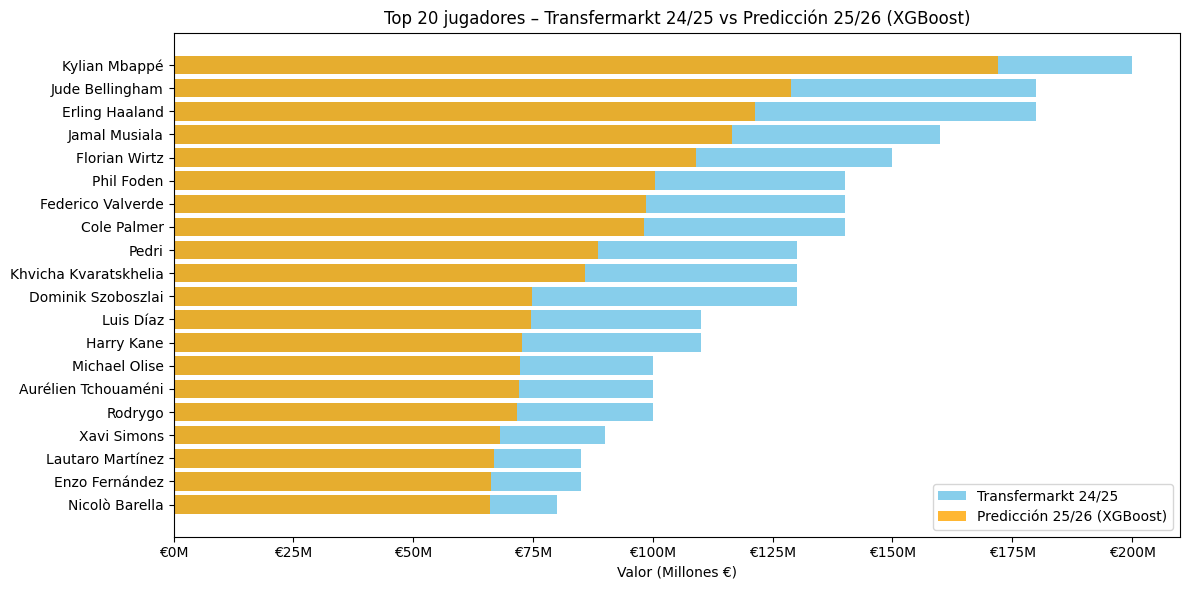

In [6]:
# ========================================
# 8. Gráfico comparativo
# ========================================
top20_plot = top50_forecast.sort_values("predicted_value", ascending=False).head(20)

plt.figure(figsize=(12,6))

# Transfermarkt actual (2024/25)
plt.barh(
    top20_plot["Player"],
    top50_current.head(20)["market_value_in_eur"] / 1e6,
    color="skyblue",
    label="Transfermarkt 24/25"
)

# Modelo predicho (2025/26)
plt.barh(
    top20_plot["Player"],
    top20_plot["predicted_value"] / 1e6,
    color="orange",
    alpha=0.8,
    label="Predicción 25/26 (XGBoost)"
)

# Mejoras de ejes
plt.xlabel("Valor (Millones €)")
plt.title("Top 20 jugadores – Transfermarkt 24/25 vs Predicción 25/26 (XGBoost)")
plt.legend()
plt.gca().invert_yaxis()

# Formato de ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"€{int(x):,}M"))

plt.tight_layout()
plt.show()


# Conclusiones – Notebook 2: Pronóstico temporada 2025/2026

### Objetivo
- Se seleccionaron los **50 jugadores más caros de la temporada 2024/2025 (Transfermarkt)**.  
- El modelo **XGBoost** se usó para **predecir sus valores para la temporada 2025/2026**.  
- El gráfico muestra el **Top 20** más valioso, comparando el valor oficial actual vs la proyección.

---

### Hallazgos principales
1. **Mantenimiento del estatus en la élite**  
   - Jugadores como *Mbappé*, *Bellingham* y *Haaland* siguen en el Top 3, confirmando su dominio en el mercado.  
   - Sin embargo, el modelo proyecta **ajustes a la baja** en algunos casos (ej. Haaland).

2. **Jóvenes al alza**  
   - *Jude Bellingham*, *Lamine Yamal* y *Cole Palmer* muestran valores proyectados en crecimiento.  
   - Esto refleja el potencial de **jóvenes talentos** como motores del mercado.

3. **Jugadores consolidados con ajustes**  
   - Figuras como *Harry Kane*, *Rodri* o *Luis Díaz* mantienen presencia en el Top 20, pero el modelo los ubica con valores más moderados frente a Transfermarkt.  
   - Se evidencia cómo el modelo captura **rendimiento y edad**, más que popularidad.

---

### Interpretación
- La **tabla del Top 50** entrega los valores proyectados en **euros (€)** para la temporada 25/26.  
- El **gráfico del Top 20** permite comparar de manera visual quiénes son los **jugadores mejor posicionados en el futuro inmediato**.

---

### Conclusión final
- El modelo XGBoost aporta una **visión predictiva** del mercado de fichajes.  
- Permite:  
  - Identificar **quiénes sostendrán o perderán valor**.  
  - Detectar a los **jóvenes talentos en ascenso** que dominarán la próxima temporada.  
  - Contrastar la percepción de Transfermarkt con una **estimación objetiva y basada en datos**.

En resumen: este pronóstico convierte al modelo en una herramienta para **anticipar tendencias del mercado de fichajes 2025/2026**, útil para clubes, analistas y scouts.
